In [23]:
from matplotlib import pyplot, patches
import csv
import os
from PIL import Image
from torchvision.models import ResNet50_Weights
import json
import math
import random

In [3]:
def recalculate_pixels(target_pixels, image_size, preprocess):
    target_x, target_y = target_pixels
    image_x, image_y = image_size

    cropped_image_x = min(image_x, preprocess.resize_size[0])
    cropped_image_y = min(image_y, preprocess.resize_size[0])
    
    new_x = float(target_x + ((cropped_image_x - preprocess.crop_size[0]) / 2))
    new_y = float(target_y + ((cropped_image_y - preprocess.crop_size[0]) / 2))


    new_x = float(new_x * (image_x / cropped_image_x))
    new_y = float(new_y * (image_y / cropped_image_y))
    
    return new_x, new_y

In [27]:
def load_target_coords(path):
    with open(path, 'r', encoding='utf-8') as f:
        scene = json.load(f)
        target_object = scene["groups"]["target"][0]
        target_x, target_y, _ = scene["objects"][target_object]["pixel_coords"]
    
    return target_x, target_y

In [33]:
def show_picture(file, dataset_root_dir, number, choose_random=True):
    with open(file, 'r', encoding='utf-8') as f:
        content = list(csv.reader(f, delimiter=','))[1:]

        if choose_random:
            images = random.sample(content, number)
        else:
            images = content[:number]
            
        for image_id, x, y in images:            
            x, y = float(x), float(y)
            target_x, target_y = load_target_coords(os.path.join(dataset_root_dir, 'scenes/', image_id))
            
            image_file_name = image_id.removesuffix('.json')
            image = Image.open(os.path.join(dataset_root_dir, 'images/', image_file_name) + '.png')

            preprocess = ResNet50_Weights.DEFAULT.transforms()
            x, y = recalculate_pixels((x, y), image.size, preprocess)

            fig, ax = pyplot.subplots()
            ax.imshow(image)
            ax.add_patch(patches.Circle((x, y), 5, linewidth=2, edgecolor='r', facecolor='none'))
            ax.add_patch(patches.Circle((target_x, target_y), 5, linewidth=2, edgecolor='g', facecolor='none'))

            ax.text(10, 20, f'distance: {round(math.dist((x, y), (target_x, target_y)), 2)}')

        pyplot.show()


In [19]:
def show_distribution(file, dataset_root_dir):
    with open(file, 'r', encoding='utf-8') as f:
        content = csv.reader(f, delimiter=',')

        first_image_path = os.listdir(os.path.join(dataset_root_dir, 'images/'))[0]
        first_image = Image.open(os.path.join(dataset_root_dir, 'images/', first_image_path))
        image_size = first_image.size
        general_fig, general_ax = pyplot.subplots()
        general_ax.imshow(first_image)

        next(content)
        for index, (image_id, x, y) in enumerate(content):            
            x, y = float(x), float(y)
            target_x, target_y = load_target_coords(os.path.join(dataset_root_dir, 'scenes/', image_id))
            
            preprocess = ResNet50_Weights.DEFAULT.transforms()
            x, y = recalculate_pixels((x, y), image_size, preprocess)

            general_ax.add_patch(patches.Circle((x, y), 1, linewidth=2, edgecolor='r', facecolor='none'))
            general_ax.add_patch(patches.Circle((target_x, target_y), 1, linewidth=2, edgecolor='g', facecolor='none'))

        pyplot.show()


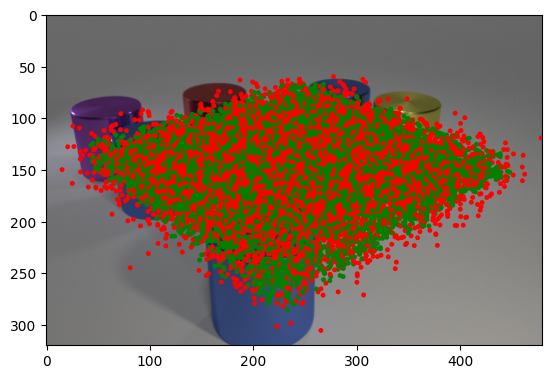

In [30]:
show_distribution('/home/dominik/Downloads/train_outputs.csv', '/home/dominik/Development/clevr-images-unambigous-colour/')

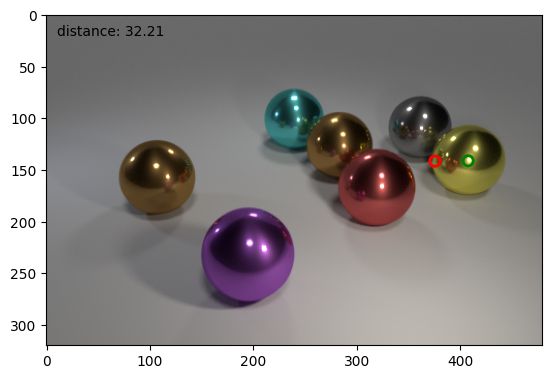

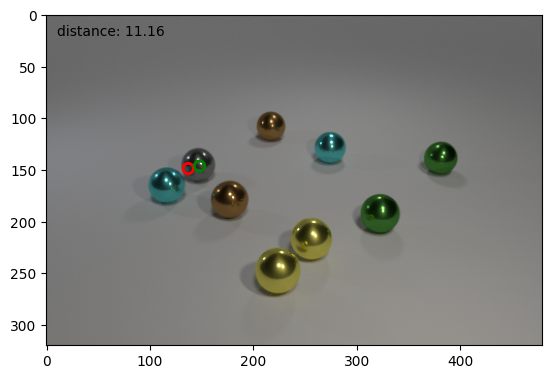

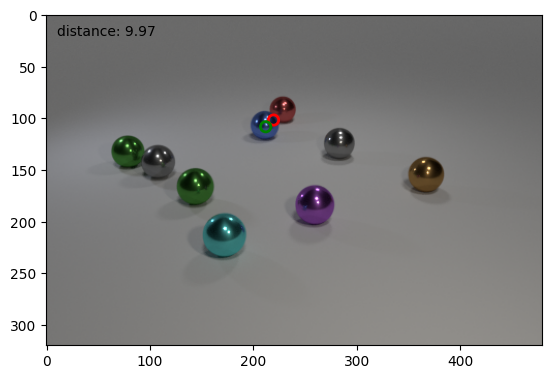

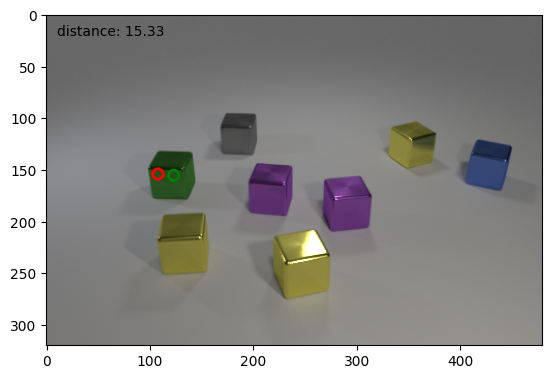

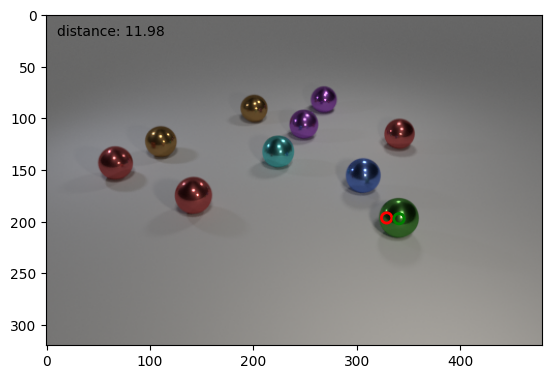

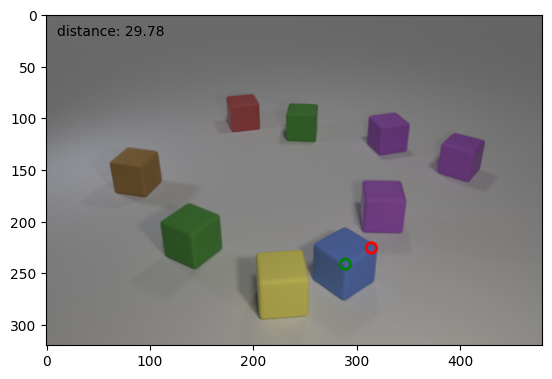

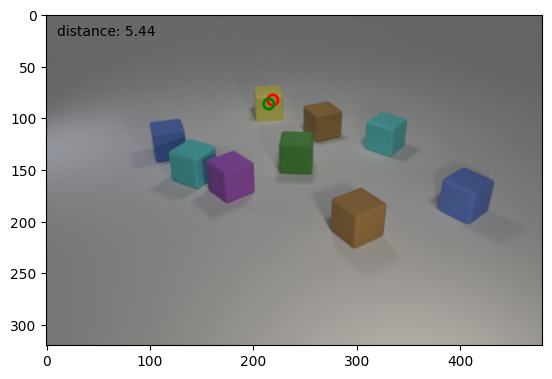

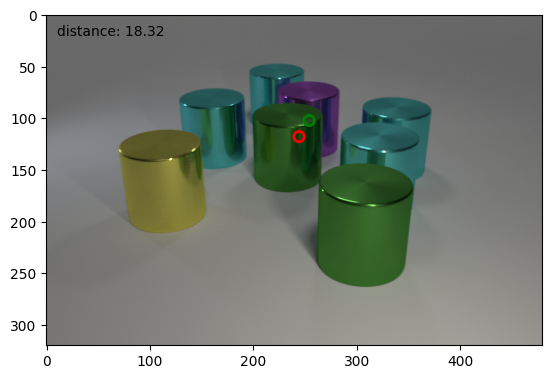

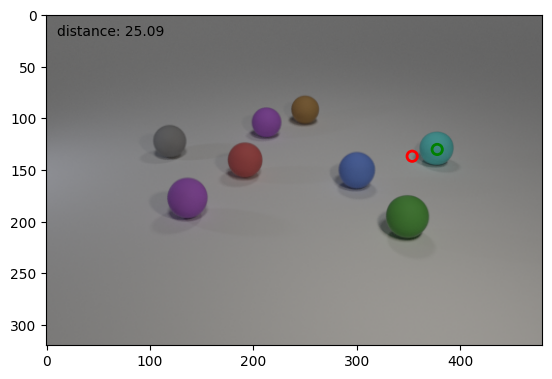

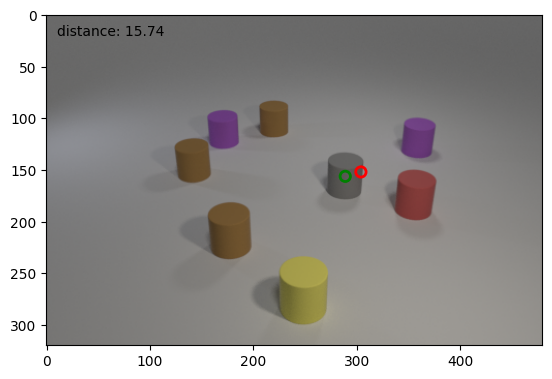

In [35]:
show_picture('/home/dominik/Downloads/train_outputs.csv', '/home/dominik/Development/clevr-images-unambigous-colour/', 10)

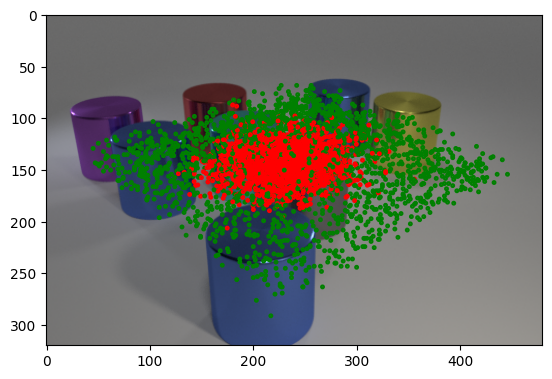

In [31]:
show_distribution('/home/dominik/Downloads/test_outputs.csv', '/home/dominik/Development/clevr-images-unambigous-colour/')

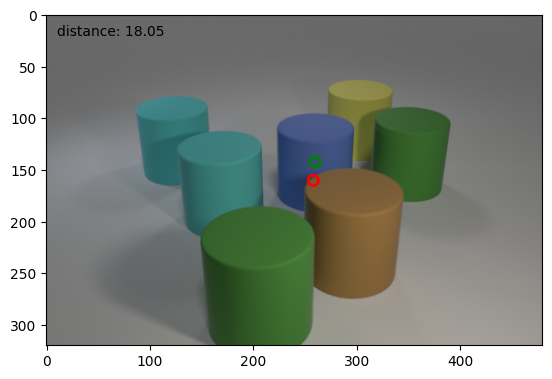

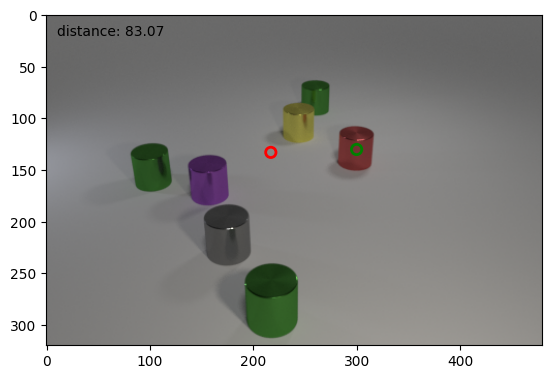

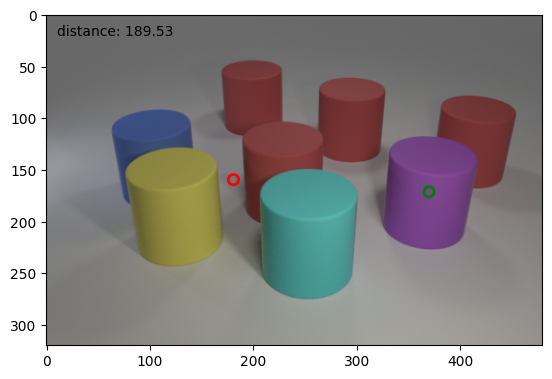

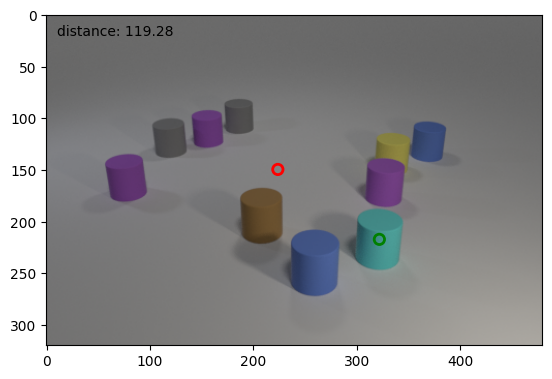

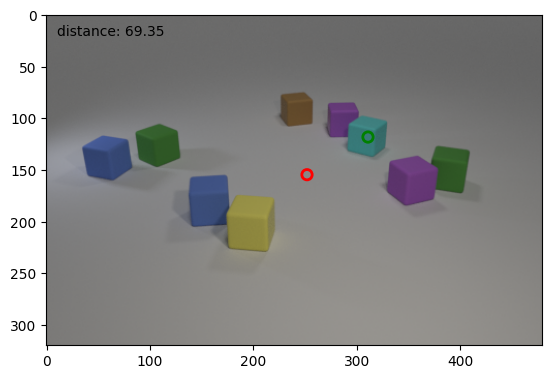

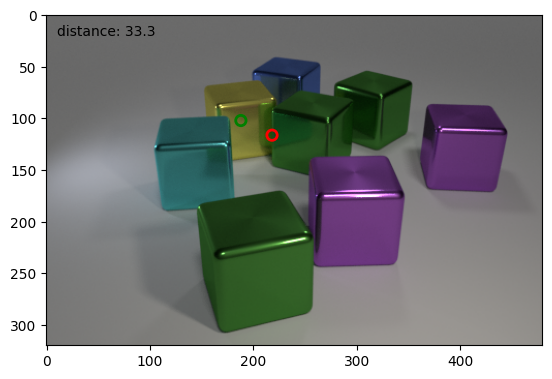

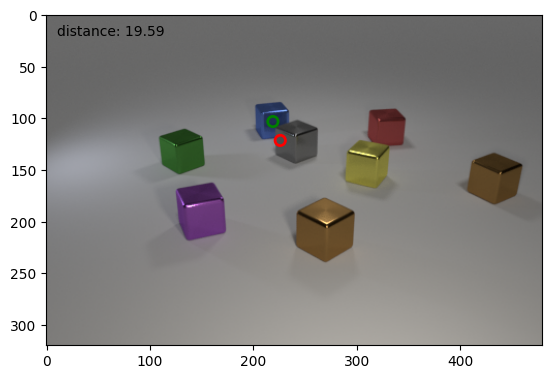

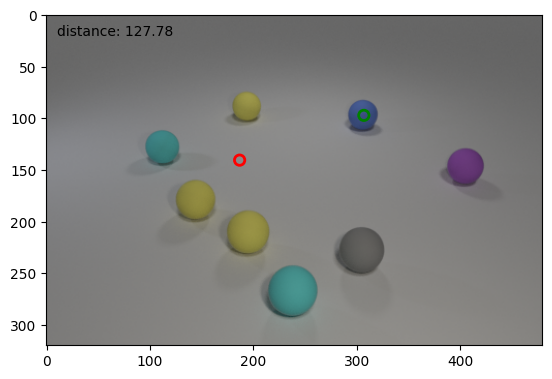

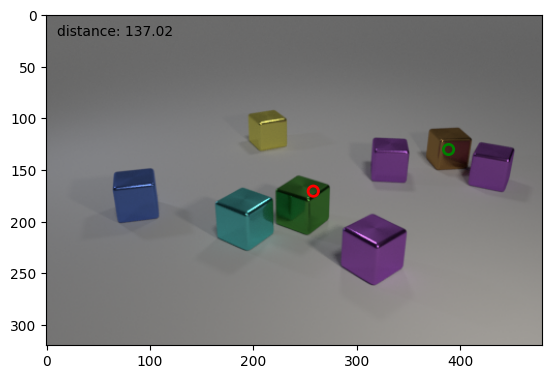

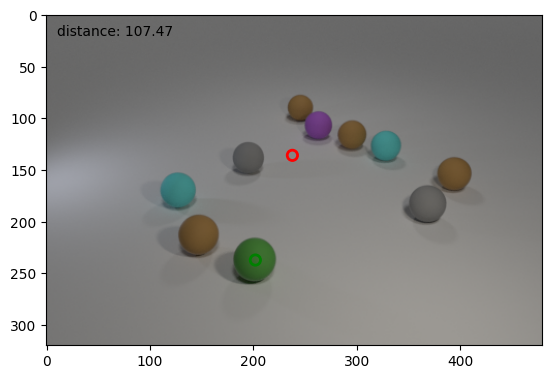

In [29]:
show_picture('/home/dominik/Downloads/test_outputs.csv', '/home/dominik/Development/clevr-images-unambigous-colour/', 10)